# Teoria

## Uczenie Temporal Difference
Metoda **model-free** oznacza, że agent uczy się jedynie poprzez doświadczenie, nie ma on dostępu do macierzy przejść MDP.
Metody Monte Carlo wymagają ukończenia całego epizodu (dopiero wtedy znana jest wartość $G_t$) zanim będzie można zaktualizować wartość $V(S_t)$.
Metody Temporal Difference natomiast mogą dokonać aktualizacji już po jednym kroku czasu

Najprostsza metoda TD dokonuje następującej aktualizacji:
$V(S_t) \leftarrow V(S_t)+\alpha[R_{r+1}+\gamma V(S_{t+1})-V(S_t)]$

Dzieje się to natychmiast po tranzycji do stanu $S_{t+1}$ oraz po otrzymaniu nagrody $R_{t+1}$.
Inaczej mówiąc, metoda ta aktualizuje wartość funkcji $V$ o mały krok $\alpha$ w kierunku celu (*TD target*), który jest w tym przypadku następujący $R_{r+1}+\gamma V(S_{t+1})$ ($G_t$ w przypadku MC). Taka metoda TD nazywana jest $TD(0)$.

Zauważmy, że wartość w nawiasach kwadratowych metody TD(0) jest pewnego rodzaju *błędem* (*TD error*), który mierzy różnicę pomiędzy estymowaną wartością $S_t$ oraz lepszą, nową estymacją $R_{r+1}+\gamma V(S_{t+1})$. Wiele algorytmów uczenia ze wzmocnieniem opartych jest na tej idei.

![](img/td0-backup.png)
Powyżej widzimy diagram dla metody TD(0). Wartość estymowana dla górnego stanu jest aktualizowana na podstawie jednej tranzycji do następnego stanu.

#### Zalety

- Nie wymagają modelu środowiska
- Może je zaimplementować jako algorytm *online*, w pełni inkrementowalnym stylu.

### SARSA
SARSA jest algorytmem **on-policy** i należy do grupy metod sterowania TD.

Jednak, zamiast uczyć się funkcji $V$, uczy się on funkcji $Q$ (funkcja action-value, która może być użyta przez agenta, kiedy nie ma on dostępu do macierzy przejść MDP).

Pierwszym krokiem metody on-policy jest estymacja $q_\pi(s,a)$ dla aktualnej strategii $\pi$ dla wszystkich stanów $s$ i akcji $a$. Możemy tego dokonać, wykorzystując metodę TD opisaną powyżej do uczenia się wartości $v_\pi$.

W poprzedniej sekcji rozważaliśmy tranzycję ze stanu do stanu i uczyliśmy się wartości stanów. Teraz będziemy rozpatrywać tranzycje z par stan-akcja do pary stan-akcja i będziemy się uczyć wartości $q_\pi$.

Aktualizacja wartości $Q$ jest następująca:
$Q(S_t, A_t) \leftarrow Q(S_t, A_t)+\alpha[R_{r+1}+\gamma Q(S_{t+1}, A_{t+1})-Q(S_t, A_t)]$

Uwaga: jest ona dokonywana po każdej tranzycji ze stanu **nieterminalnego**.

![](img/sarsa-backup.png)
Powyżej przedstawiony jest diagram dla algorytmu SARSA.

![](img/sarsa.png)

### Q-learning

Jedną z przełomowych metod uczenia ze wzmocnieniem była metoda off-policy *Q-learning* (również oparta na idei TD).

Formuła aktualizacji wartości $Q$:
$Q(S_t, A_t) \leftarrow Q(S_t, A_t)+\alpha[R_{r+1}+\gamma \max_a Q(S_{t+1}, a)-Q(S_t, A_t)]$

W tym przypadku uczona funkcja $Q$, bezpośrednio przybliża $q_*$, czyli optymalną funkcję action-value. Jest ona niezależna od strategii jaką kieruje się agent w środowisku (stąd off-policy)

![](img/q-learning-backup.png)
Jak widzimy z powyższego diagramu, do aktualizacji wartości $Q$ używamy $\max$ nad wszystkimi możliwymi akcjami (w SARSA używaliśmy tej samej akcji, co agent wykonał w środowisku). To pokazuje, że używamy tak naprawdę dwóch strategii: jednej do zachowania agenta oraz drugiej do aktualizacji wartości $Q$.

![](img/q-learning.png)

In [140]:
#!pip install -U gym 
#!pip install pygame
#!pip install matplotlib

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


You should consider upgrading via the 'C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
import pkg_resources

gym_version = pkg_resources.get_distribution("gym").version
print(gym_version)

0.26.2


# Kod

In [111]:
import gym
import numpy as np
import time

W tym zadaniu wykorzystamy środowisko [Taxi-v3](https://www.gymlibrary.dev/environments/toy_text/taxi/) z biblioteki Gym OpenAI.

Zdefiniujmy strategię $\epsilon-greedy$ do eksploracji środowiska.

In [6]:
def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    #print(s)
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s[0], :])
    else:
        action = np.random.randint(0, n_actions)
    return action

Inicjalizacja wartości $Q$.

In [7]:
def init_q_values(s, a, type="ones"):
    if type == "ones":
        return np.ones((s, a))
    elif type == "random":
        return np.random.random((s, a))
    elif type == "zeros":
        return np.zeros((s, a))

Implementacja algorytmu SARSA.

In [106]:
def sarsa(alpha, gamma, epsilon, episodes, max_steps):
    env = gym.make('Taxi-v3', render_mode="ansi")
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = init_q_values(n_states, n_actions, type="ones")
    #print(Q[0][0])
    timestep_reward = []
    amount_of_prohibited_actions = []
    for episode in range(episodes):
        total_reward = 0
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        amount_of_prohibited_actions.append(0)
        while t < max_steps:
            
            t += 1
            s_, reward, done, info, s__ = env.step(a)
            #edit for version 0.26.2
            s_ = (s_, s__)
            total_reward += reward
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            Q[s[0]][a] = Q[s[0]][a] + alpha*(reward+(gamma*Q[s_[0], a_])-Q[s[0]][a])
            '''
            Implementacja aktualizacji SARSA
            '''
            if s_[0] == s[0] and reward < 0:
                #kiedy uderza w ściane lub podnosi/opuszcza źle
                amount_of_prohibited_actions[episode] = amount_of_prohibited_actions[episode] + 1
            if episode == episodes-1:
                #print(done)
                #print(info)
                print(reward)   
                print(env.render())

            s, a = s_, a_
            if done:
                #print("done!")
                timestep_reward.append(total_reward)
                break
        #if episode%100 == 0:
        #    print(episode)
    print(reward)
    print(env.render())
    return timestep_reward, amount_of_prohibited_actions, Q

In [107]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
timestep_reward_sarsa, amount_of_prohibited_actions_sarsa, Q_sarsa = sarsa(alpha, gamma, epsilon, episodes, max_steps)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
|

In [107]:
print(timestep_reward)

[-2023, -3803, -3844, -272, -1956, -1744, -2068, -594, -76, -1569, -2313, -1328, -443, -164, -1699, -1235, -950, -96, -374, -857, -80, -1115, -357, -378, -299, -18, -24, -406, -173, -87, -226, -198, -416, -613, -112, -287, -331, -146, -500, -77, -202, -46, -358, -597, -221, -130, 14, -176, -31, -170, -307, -8, -323, -178, -69, -783, -95, -393, -178, -187, -25, -153, -102, -49, -157, -1295, -165, -101, -242, -73, -41, -63, -206, -144, -391, -337, -161, -239, -205, -123, -33, -169, -135, -63, -112, -565, -322, -26, -344, -169, -201, -296, 10, -8, -307, -82, -63, -70, -579, 8, -209, -12, -170, 5, -66, -26, 0, -62, -15, -88, -42, -128, 1, -49, -276, -109, -13, -50, -77, -426, -105, -246, 5, -21, 11, -88, -124, -28, -234, 10, -49, -8, -278, -8, -224, -113, -42, 12, -83, -10, -322, -80, -109, 5, 2, -36, -384, 5, -135, 8, -7, -1, -19, -45, 8, 4, -339, 6, -67, -1, -48, -92, -36, -17, -14, -8, -89, 9, -99, -69, -53, -25, -45, -143, -19, -34, -149, 11, -219, -2, -102, 14, 9, -39, -92, -2, -234, 

Uruchomienie SARSA.

In [32]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
timestep_reward = sarsa(alpha, gamma, epsilon, episodes, max_steps)
print(timestep_reward)

[-758, -713, -704, -749, -668, -596, -713, -776, -740, -335, -659, -695, -686, -637, -686, -609, -569, -686, -596, -542, -488, -542, -263, -695, -452, -272, -488, -333, -389, -227, -344, -308, -263, -308, -272, -704, -632, -272, -205, -263, -245, -389, -301, -317, -425, -263, -251, -109, -254, -299, -272, -245, -308, -209, -245, -740, -263, -176, -254, -389, -236, -263, -161, -245, -416, -254, -254, -245, -236, -127, -272, -263, -380, -49, -137, -226, -91, -140, -80, -184, -181, -299, -281, -128, -166, -11, -326, -254, -317, -245, -362, -138, 12, -245, -54, -60, -36, -155, 11, -254, -25, -425, -10, -245, -218, -149, -236, -290, -93, -86, -371, -248, -148, -118, -245, -164, -132, -189, -39, -130, -39, -263, -118, -127, -30, 11, -233, -18, -258, -299, -281, -201, -134, -197, -169, -317, -267, -245, -98, -163, -82, -213, -240, -290, -425, 8, -5, -160, -173, -218, -162, -49, -56, -71, -268, -17, -131, -290, -299, -380, -256, -18, -52, -74, -48, -20, -51, -7, -10, -135, -205, -21, -50, -18,

Implementacja algorytmu Q-learning.

In [108]:
def qlearning(alpha, gamma, epsilon, episodes, max_steps):
    env = gym.make('Taxi-v3', render_mode="ansi")
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = init_q_values(n_states, n_actions, type="ones")
    timestep_reward = []
    amount_of_prohibited_actions = []
    for episode in range(episodes):
        s = env.reset()
        t = 0
        total_reward = 0
        amount_of_prohibited_actions.append(0)
        while t < max_steps:
            t += 1
            a = epsilon_greedy(Q, epsilon, n_actions, s) #tu zmieniłem, bo w algorytmie, jest żeby oddzielnie dla każdego kroku wybierać a, a nie brać ostatnie a.
            s_, reward, done, info, s__ = env.step(a)
            s_ = (s_, s__)
            #print(reward)
            total_reward += reward
            a_ = np.argmax(Q[s_[0], :])
            '''
            Implementacja aktualizacji Q-learning
            '''
            Q[s[0]][a] = Q[s[0]][a] + alpha*(reward+(gamma*Q[s_[0], a_])-Q[s[0]][a])
            
            if s_[0] == s[0] and reward < 0:
                #kiedy uderza w ściane lub podnosi/opuszcza źle
                amount_of_prohibited_actions[episode] = amount_of_prohibited_actions[episode] + 1
            if episode == episodes-1:
                #print(done)
                #print(info)
                print(reward)   
                print(env.render())
            
            s = s_ #tu zmieniłem, bo w algorytmie, jest żeby oddzielnie dla każdego kroku wybierać a, a nie brać ostatnie a.
            #s, a = s_, a_
            #s = s_
            
            if done:
                timestep_reward.append(total_reward)
                break
    print(reward)
    print(env.render())
    return timestep_reward, amount_of_prohibited_actions, Q

In [109]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
timestep_reward_qlearning, amount_of_prohibited_actions_qlearning, Q__qlearning = qlearning(alpha, gamma, epsilon, episodes, max_steps)
print(timestep_reward)
print(render)


-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

-1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

-1
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

-1
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

-1
+---------+
|R: | : 

Uruchomienie Q-learning

In [34]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
#timestep_reward = qlearning(alpha, gamma, epsilon, episodes, max_steps)
print(timestep_reward)

[-740, -776, -731, -740, -488, -551, -93, -596, -308, -704, -776, -659, -668, -416, -668, -452, -200, -560, -668, -740, -101, -29, -200, -776, -359, -632, -308, -740, -560, -488, -668, -560, -560, -524, -158, -335, -452, -89, -411, -506, -434, -158, -236, -200, -133, -136, 6, -200, -227, -740, -86, -308, -80, -200, -181, -200, -26, -200, -200, -200, -138, -73, -200, -200, -145, -200, -200, -116, -200, -69, -42, -14, -118, 12, -200, -107, -112, -108, -102, -200, -200, -200, -200, -35, -15, -168, -96, -154, -200, -200, -200, -92, -147, -126, -33, -200, 9, -6, -45, -200, -61, -72, -176, -200, -85, -140, -86, -42, -28, -200, -46, -9, -81, -200, -8, -131, -15, -31, -102, -200, -81, -5, -163, -268, -113, -7, -21, -187, 1, -264, -135, -119, -152, -117, -85, -144, -143, -105, -126, -200, 4, -183, -257, -93, -36, -2, -476, -80, -200, -121, -35, 0, -60, -163, -18, -170, -156, -200, -113, -109, -6, 9, -127, -121, -74, -450, -434, -16, -86, -750, -239, -61, -4, -101, 5, -152, -3, 9, -219, -8, -37,

# Funkcja testująca z zad 2

In [134]:
env = gym.make('Taxi-v3', render_mode="ansi")
n_states, n_actions = env.observation_space.n, env.action_space.n
def test_agent(Q, env, n_tests, n_actions, delay=0.1):
    amount_of_prohibited_actions = []
    for test in range(n_tests):
        amount_of_prohibited_actions.append(0)
        s = env.reset()
        done = False
        total_reward = 0
        while True:
            time.sleep(delay)
            env.render()
            a = epsilon_greedy(Q, epsilon, n_actions, s, train=False)
            #print(f"Chose action {a} for state {s}")
            old_s = s
            s, reward, done, info, s_ = env.step(a)
            s = (s, s_)
            
            if old_s[0] == s[0] and reward < 0:
                #kiedy uderza w ściane lub podnosi/opuszcza źle
                amount_of_prohibited_actions[test] = amount_of_prohibited_actions[test] + 1
            total_reward += reward
            if done:
                #print(f"Episode reward: {total_reward}")
                if test % 10 == 0:
                    print("number test: ", test)
                #time.sleep(1)                   
                break
    return amount_of_prohibited_actions
#test_agent(Q, env, 100, n_actions)

In [135]:
amount_of_prohibited_actions_sarsa = test_agent(Q_sarsa, env, 100, n_actions)

number test:  0
number test:  10
number test:  20
number test:  30
number test:  40
number test:  50
number test:  60
number test:  70
number test:  80
number test:  90


In [136]:
amount_of_prohibited_actions_qlearning = test_agent(Q__qlearning, env, 100, n_actions)

number test:  0
number test:  10
number test:  20
number test:  30
number test:  40
number test:  50
number test:  60
number test:  70
number test:  80
number test:  90


# Wykresy przedstawiające ilość akcji zabronionych w danym epizodzie

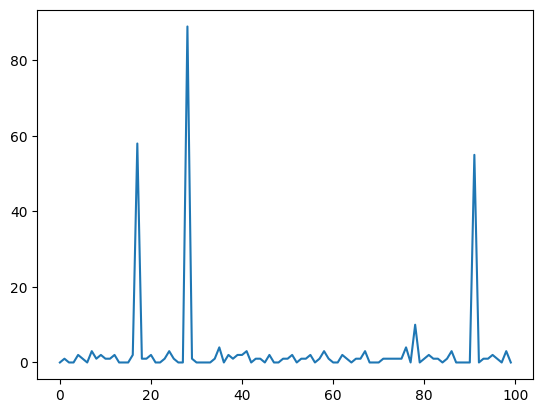

In [144]:
import matplotlib.pyplot as plt
Y = list(range(len(amount_of_prohibited_actions_sarsa)))
plt.plot(Y, amount_of_prohibited_actions_sarsa)

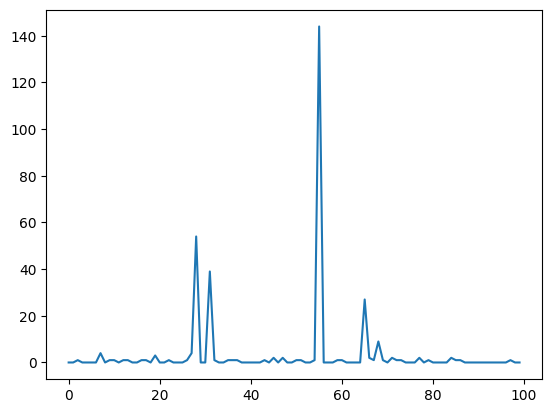

In [145]:
import matplotlib.pyplot as plt
Y = list(range(len(amount_of_prohibited_actions_qlearning)))
plt.plot(Y, amount_of_prohibited_actions_qlearning)

Moim zdaniem dałoby się wyszkolić tak agenta, żeby nie popełnił błędów w żadnym z epizodów. Jednakże warto tutaj podkreślić, że sam model to nie do końca wspiera.

Akcja zabroniona w postaci uderzenia w ściane w ogóle nie była logowana i musiałem ten problem ręcznie rozwiązać (uznałem, że zostanie w miejscu przy ujemnym wyniku to akcja zabroniona - bo albo uderzenie w ściane, albo podniesienie/upuszczenie nieprawidłowe).

Żeby dobrze wyszkolić agenta to należałoby zmodyfikować wartość nagrody dla uderzenia w ściane, żeby w nią nie uderzał, ponieważ teraz nagroda w tym miejscu wynosi na -1. Mógłbym zmodyfikować wartość reward dla takiej sytuacji, ale uznałem, że nie będę poprawiał w ten sposób modelu

(Przykładowo mogłem robić takie samo sprawdzenie "if s_[0] == s[0] and reward < 0: reward = -10" i powinno wtedy dobrze zadziałać).

Ale, po poprawieniu uważam, że dałoby się tak wyszkolić agenta, żeby nie popełniał błędów. Nie ma powodu dla którego by się nie dało. Warunki w których agent trenuje się nie zmieniają więc w końcu agent powinnien nauczyć się obierać optymalną trasę.
Minusem tego byłoby to, że prawdopodobnie mogłoby dojść do przetrenowania, ale to już jest inny temat.

# Zad 3

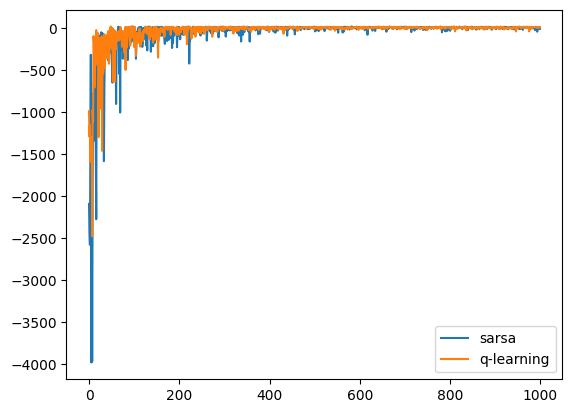

In [141]:
import matplotlib.pyplot as plt
Y = list(range(len(timestep_reward_qlearning)))
X = list(range(len(timestep_reward_sarsa)))
plt.plot(X, timestep_reward_sarsa, label='sarsa')
plt.plot(X, timestep_reward_qlearning, label='q-learning')
plt.legend()

# Zadanie

1. Uzupełnij puste miejsca w kodzie dla algorytmu SARSA oraz Q-learning.
2. Napisz metodę, która będzie oceniała zachowanie agenta. Pokaż wizualnie, jak zachowuje się agent, używając wyuczonej strategii (użyj `env.render()`). Dodatkowo dokonaj ewaluacji swojego agenta na przestrzeni 100 epizodów - ile razy popełnił błąd (wykonał akcję zabronioną)? Czy można wytrenować agenta w ten sposób, aby nie popełnił błędu w żadnym z epizodów?
3. Pokaż wykres, który wizualizuje proces uczenia się agenta. Innymi słowy, pokaż całkowitą nagrodę, jaką osiągnął agent za każdy epizod uczenia. Przedstaw na jednym wykresie wyniki dla obu algorytmów.

## Materiały

- [RL Course by David Silver - Lecture 5: Model Free Control](https://www.youtube.com/watch?v=0g4j2k_Ggc4&list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-&index=9)
- Sutton, Barto - Chapter 6